**Table of contents**<a id='toc0_'></a>    
- [The full model building process](#toc1_)    
  - [Working with data](#toc1_1_)    
  - [Creating models](#toc1_2_)    
  - [Optimizing the model parameters](#toc1_3_)    
  - [Saving Models](#toc1_4_)    
  - [Loading Models](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# <a id='toc1_'></a>[The full model building process](#toc0_)

## <a id='toc1_1_'></a>[Working with data](#toc0_)

PyTorch has two primitives to work with data: 
```
torch.utils.data.DataLoader and 
torch.utils.data.Dataset. 

Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset.
```


In [3]:
# Every TorchVision Dataset includes two arguments: 
# transform and target_transform to modify the samples and labels respectively.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


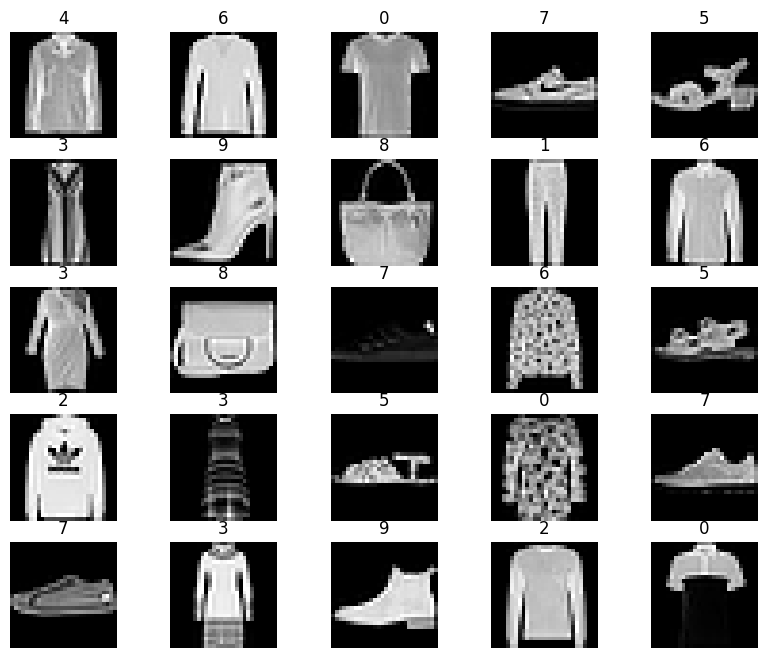

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break
    
# Display sample data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## <a id='toc1_2_'></a>[Creating models](#toc0_)

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## <a id='toc1_3_'></a>[Optimizing the model parameters](#toc0_)

- using nn.CrossEntropyLoss for loss and Stochastic Gradient Descent for optimization

In [6]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# In a single training loop, the model makes predictions on the training dataset (fed to it in batches), 
# and back-propagates the prediction error to adjust the model's parameters.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
# check the model's performance against the test dataset to ensure it is learning.
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308456  [    0/60000]
loss: 2.299269  [ 6400/60000]
loss: 2.289019  [12800/60000]
loss: 2.280347  [19200/60000]
loss: 2.280794  [25600/60000]
loss: 2.280709  [32000/60000]
loss: 2.265855  [38400/60000]
loss: 2.263960  [44800/60000]
loss: 2.263621  [51200/60000]
loss: 2.241510  [57600/60000]
Test Error: 
 Accuracy: 44.3%, Avg loss: 0.035158 

Epoch 2
-------------------------------
loss: 2.253121  [    0/60000]
loss: 2.233291  [ 6400/60000]
loss: 2.204155  [12800/60000]
loss: 2.199718  [19200/60000]
loss: 2.195789  [25600/60000]
loss: 2.211153  [32000/60000]
loss: 2.177721  [38400/60000]
loss: 2.176199  [44800/60000]
loss: 2.185940  [51200/60000]
loss: 2.140216  [57600/60000]
Test Error: 
 Accuracy: 46.9%, Avg loss: 0.033546 

Epoch 3
-------------------------------
loss: 2.167505  [    0/60000]
loss: 2.125703  [ 6400/60000]
loss: 2.066031  [12800/60000]
loss: 2.065175  [19200/60000]
loss: 2.050688  [25600/60000]
loss: 2.093723  [32000/600

## <a id='toc1_4_'></a>[Saving Models](#toc0_)

In [10]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## <a id='toc1_5_'></a>[Loading Models](#toc0_)


In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("data/model.pth"))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
